### Importation des bilbliothèques

In [1]:
import matplotlib.pyplot as plt

import numpy as np

import cv2
import time
from skimage import color, transform
from skimage.feature import hog
import imutils

import joblib

In [2]:
positive_patches_shape = (62, 47)

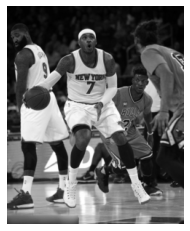

In [32]:
test_image = cv2.imread('img/basket.jpeg') 

test_image = color.rgb2gray(test_image)

# Paramètre dont on étudiera l'influence
(H_MAX, W_MAX) = (300, 600)

if test_image.shape[0] > H_MAX or test_image.shape[1] > W_MAX:
    s = min(H_MAX / test_image.shape[0], W_MAX / test_image.shape[1])
    test_image = transform.rescale(test_image, s)

plt.imshow(test_image, cmap="gray")
plt.axis('off');

Ici, on va mettre en place les méthodes de image pyramid et sliding window

In [33]:
def pyramid(image, scale=1.5, minSize=(30, 30)):
    yield image

    while True:
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        
        yield image

In [34]:
def sliding_window(img, patch_size,
                   istep=4, jstep=4, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

### Extraction des patches

La pyramide présente 4 couches.
On a un total de 3872 patches.


<ipython-input-42-54aaa2087fd0>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


(3872, 1215)

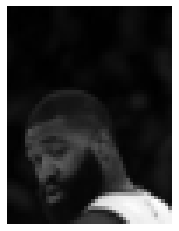

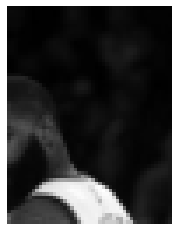

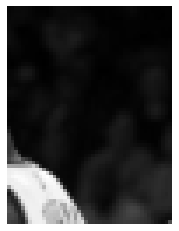

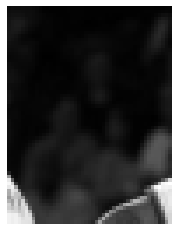

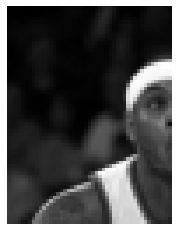

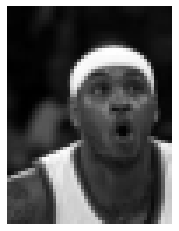

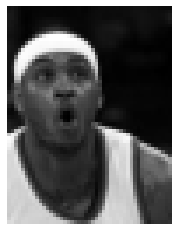

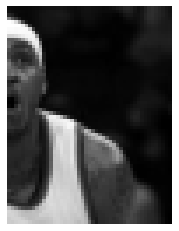

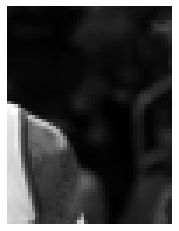

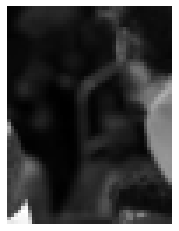

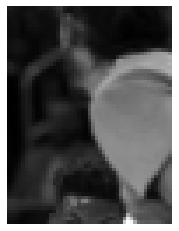

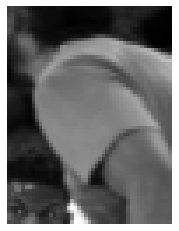

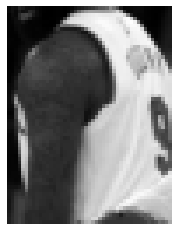

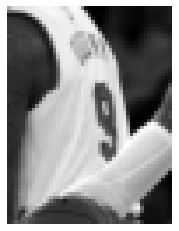

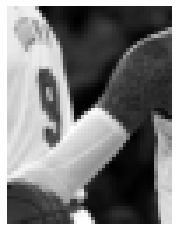

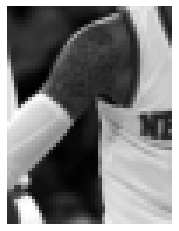

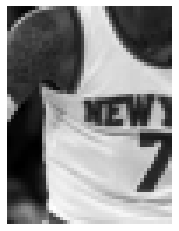

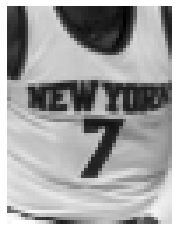

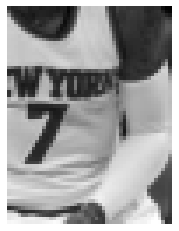

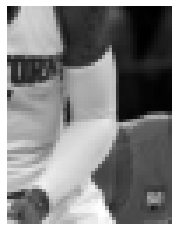

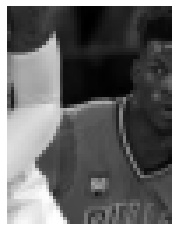

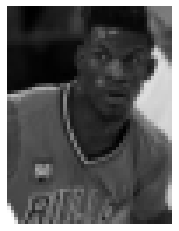

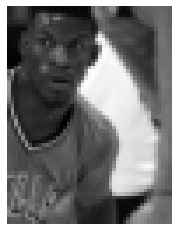

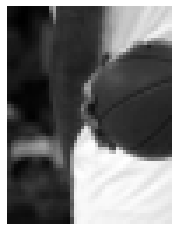

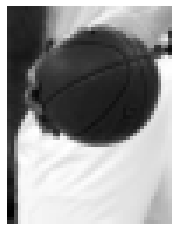

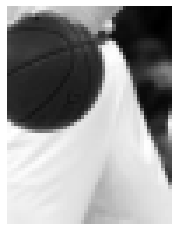

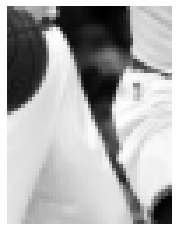

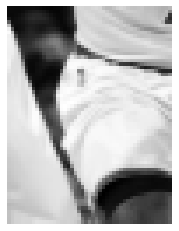

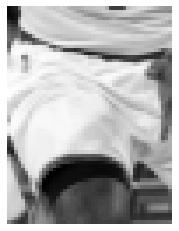

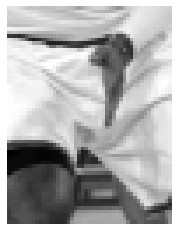

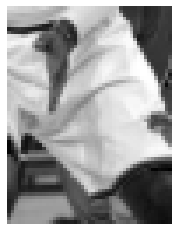

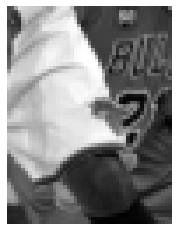

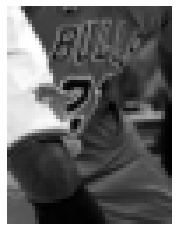

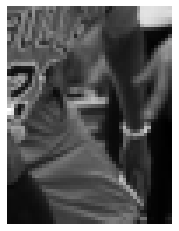

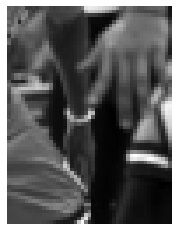

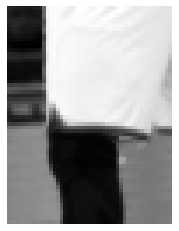

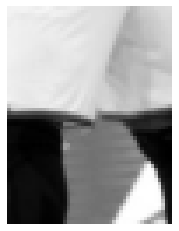

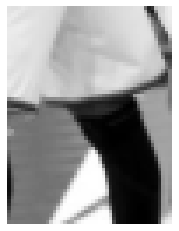

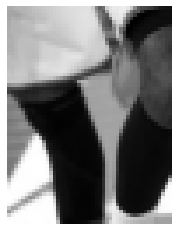

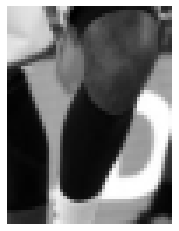

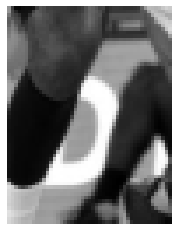

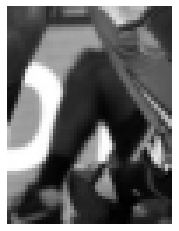

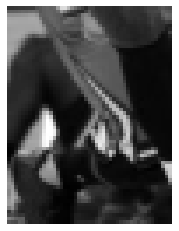

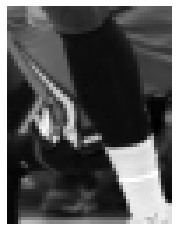

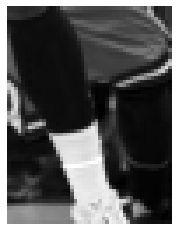

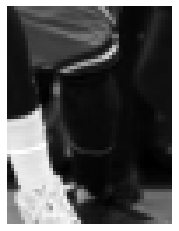

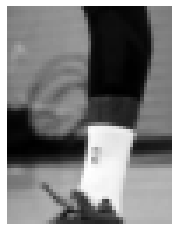

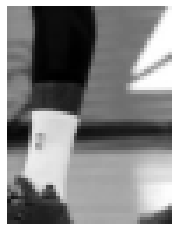

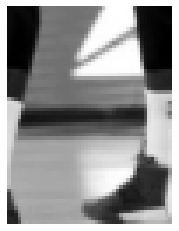

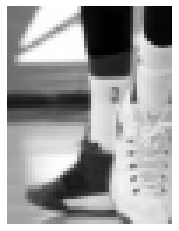

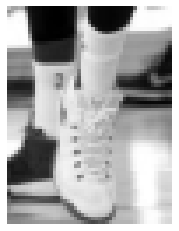

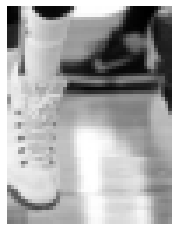

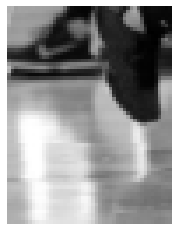

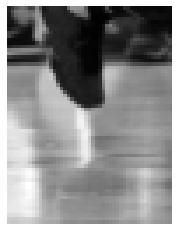

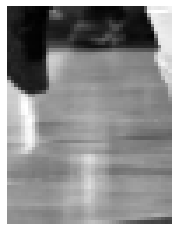

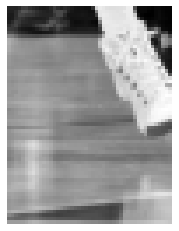

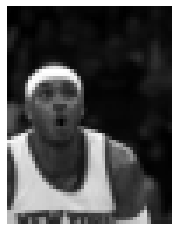

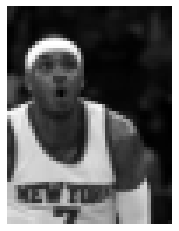

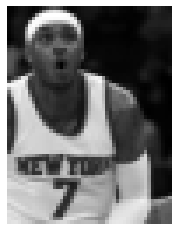

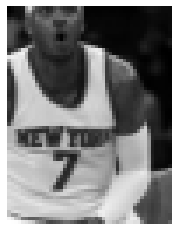

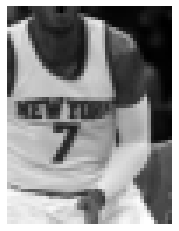

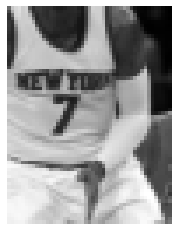

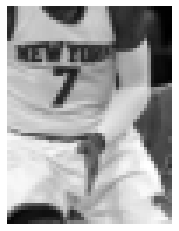

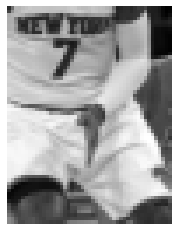

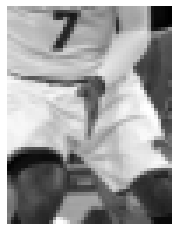

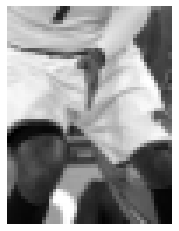

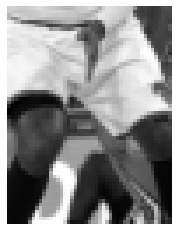

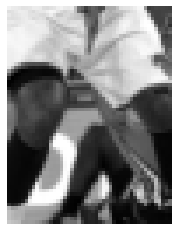

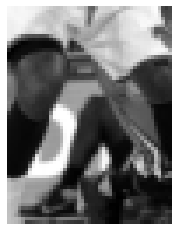

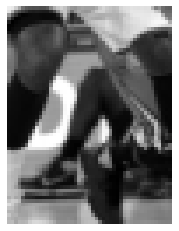

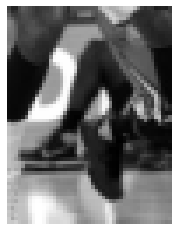

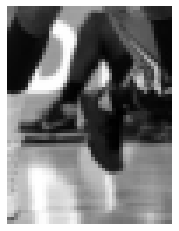

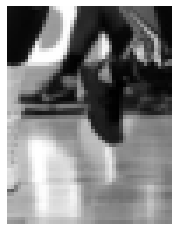

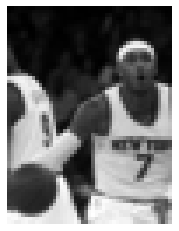

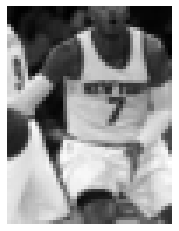

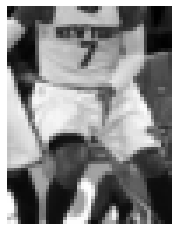

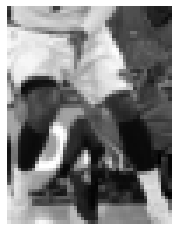

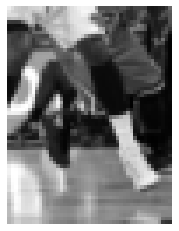

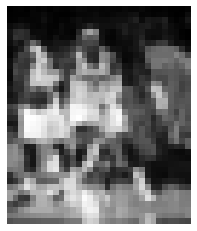

In [42]:
indices, patches = [], []

pyrlayers = 0
for (i, resized) in enumerate(pyramid(test_image)):
    try:                  # STRUCTURE À AMÉLIORER
        # On applique la sliding window sur la couche de la pyramide en cours
        pyrindices, pyrpatches = zip(*sliding_window(resized, positive_patches_shape, scale=1.0))
        
        indices += pyrindices
        patches += pyrpatches
        
        pyrlayers += 1
    except:
        pass
    
print("La pyramide présente {} couches.".format(pyrlayers))
print("On a un total de {} patches.".format(len(patches)))
    
indices = np.array(indices)

for i in range(0, len(patches), 50):
    fig, ax = plt.subplots()
    ax.imshow(patches[i], cmap='gray')
    ax.axis('off')
        
fig, ax = plt.subplots()
ax.imshow(resized, cmap='gray')
ax.axis('off')
        
#Ni, Nj = positive_patches_shape

#for i, j in indices:
    #ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))
            
patches_hog = np.array([hog(patch) for patch in patches])
patches_hog.shape

### Prédiction

In [43]:
# Chargement du modèle
filename = 'temp_model.sav'
loaded_model = joblib.load(filename)

# Prédictions
labels = loaded_model.predict(patches_hog)
print("{} zones positives trouvées.".format(labels.sum()))

35.0 zones positives trouvées.


### Affichage des résultats

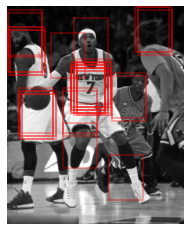

In [44]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches_shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

Possiblement un problème sur l'affichage des zones labelisées positives; les indices des zones 

Il faut encore combiner les patches qui se superposent